# Modelling Using Term Frequency - Inverse Document Frequency
To create an accurate predictive model which determines how well someone did on their virtual internship there are two potential general methods:
* Using the provided tabular data
* Use a numeric representation of the chat transcripts

Although interpreting written text is far more difficult than creating a tabular classifier, it has greater overall potential.
This is because the given tabular data does not provide enough information to make an informative decision on how well or badly someone faired.

In [1]:
import pandas as pd
import numpy as np

from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, classification_report, accuracy_score, f1_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, loguniform, randint
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

from matplotlib import pyplot as plt
from xgboost import XGBClassifier

## Data Processing
Before we can begin creating models to predict peoples scores we have to ensure that the data is cleaned and interpretable.

The process begins with removing messages sent by the mentor.
These are preset with an average rating of 4 to avoid modifying any average statistics run on the dataset.
However, they do not add any value to the analysis and further skew the datasets mode towards the average mean result.

Secondly we oversample the minority classes which have less samples.
This mitigates our models seeing very few highly-rated and low-rated scores, whilst at the same time a very very large number of average ratings (class imbalance).
To finish off we ensure that this though does not happen to the test dataset, as we want to see how it fairs on the actual problem (having duplicates does help).
We utilise random state seeds to ensure that this all happens the exact same way each time.

In [2]:
df = pd.read_csv("../data/data.csv")
df = df[df["RoleName"] != "Mentor"]

In [3]:
ros = RandomOverSampler(random_state=0)
x_resampled, y_resampled = ros.fit_resample(df[["content"]], df["OutcomeScore"])
x_train, x_test, y_train, y_test = train_test_split(x_resampled["content"], y_resampled, train_size=0.8, random_state=0)
_, x_test, _, y_test = train_test_split(df["content"], df["OutcomeScore"], train_size=0.8, random_state=0) # test on imbalanced data

## Model Training
We will test a variety of models to see how different models fair.
Models include logistic regression (baseline),  naive bays, k-nearest neighbors, decision trees and ensemble models such as random forests and (normal/extreme) gradient boosting.
The selection is designed to accentuate which types of models are most likely to work well for classification of grades based on sparse text.


Upon first tests, all models go through a hyperparameter optimisation process.
Instead of tuning all hyperparameters, a small selection are chosen per model which either alter how the models function (e.g. optimisation routines) or how conservative they are (e.g. max depth).
Hyperparameter values are randomly selected within their specified range and in the end to combination which produces the highest weighted f1 score is chosen.
F1 scores are prefered over accuracy simple to avoid situations where either precission or recall is high whilst the other low.
Due to the large computational and time cost in hyperparameter selection, the process is only rerun for models where it resulted in sizable improvementns (based on further evaluation).
This is the case for the baseline logistic regression model.
Other optimisation routines are commented out and the basic pipeline is selected instead.


Note that although these models aren't trained using K-Fold cross validation, this happens later on in the evaluation section for the best and worst model.
This statistically ensures that the results are sound and not simply due to overfitting or a randomly easy/hard dataset (for example one with very few examples of high scoring messages will struggle on the test set).


We will prioritise testing two types of models:
* Random Forests - An Ensemble of Decision Trees
* Logistic Regression


To simplify the creation and usage of these models we will compose several pipelines.
Each of these will start with a TF-IDF vectoriser (to transform the text into a matrix of numbers) and after this proceed with a classifier (like logistic regression).
Term Frequency - Inverse Document Frequency (TF-IDF) models provide a standard way to go from text to a numeric vector representation of data.
This works by first calculating the number of times each word is used in total and in every separate document.
This can be divided and used as numeric data in future models like random forests and logistic regression.

In [4]:
# baseline_clf = make_pipeline(TfidfVectorizer(), SelectKBest(chi2, k=2000), LogisticRegression(random_state=0, solver="newton-cg", max_iter=500))

baseline_clf = make_pipeline(
    TfidfVectorizer(),
    SelectKBest(chi2, k=2000),
    RandomizedSearchCV(
        LogisticRegression(random_state=0, solver="lbfgs", penalty="none", max_iter=500),
        {
#             "solver": ["newton-cg", "lbfgs"], # newton-cg offers most relaible convergence
#             "penalty": ["l1", "l2", "elasticnet", "none"], # penalty causes significant performance loss
            "tol": loguniform(1e-5, 1e-3),
#             "C": loguniform(1e-5, 100) # comment out if using no penalty
        },
        n_jobs=3, n_iter=50, cv=2,
        scoring="f1_weighted"
    ),
)

baseline_clf.fit(x_train, y_train);
# baseline_clf = make_pipeline(TfidfVectorizer(), SelectKBest(chi2, k=2000), baseline_clf["randomizedsearchcv"].best_estimator_)
baseline_clf["randomizedsearchcv"].best_params_

C:\Users\kamwi\miniconda3\envs\vi\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


{'tol': 9.647000845443023e-05}

In [5]:
# naive_bayes_clf = make_pipeline(TfidfVectorizer(), SelectKBest(chi2, k=1000), MultinomialNB())

naive_bayes_clf = make_pipeline(
    TfidfVectorizer(),
    SelectKBest(chi2, k=2000),
    RandomizedSearchCV(
        MultinomialNB(),
        {
            "alpha": uniform(0, 3),
            "fit_prior": [True, False]
        },
        n_jobs=3, n_iter=100, cv=2,
        scoring="f1_weighted"
    )
)

naive_bayes_clf.fit(x_train, y_train);
naive_bayes_clf["randomizedsearchcv"].best_params_

{'alpha': 0.02604293068856456, 'fit_prior': True}

In [6]:
# k_nearest_neighbors_clf = make_pipeline(TfidfVectorizer(), SelectKBest(chi2, k=2000), KNeighborsClassifier())

k_nearest_neighbors_clf = make_pipeline(
    TfidfVectorizer(),
    SelectKBest(chi2, k=2000),
    RandomizedSearchCV(
        KNeighborsClassifier(),
        {
            "n_neighbors": [5, 7, 9],
            "weights": ["uniform", "distance"],
            "metric": ["euclidean", "manhattan", "minkowski"]
        },
        n_jobs=3, n_iter=100, cv=2,
        scoring="f1_weighted"
    )
)

k_nearest_neighbors_clf.fit(x_train, y_train);
k_nearest_neighbors_clf["randomizedsearchcv"].best_params_

C:\Users\kamwi\miniconda3\envs\vi\lib\site-packages\sklearn\model_selection\_search.py:289: UserWarning: The total space of parameters 18 is smaller than n_iter=100. Running 18 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)


{'weights': 'distance', 'n_neighbors': 7, 'metric': 'manhattan'}

In [7]:
# decision_tree_clf = make_pipeline(TfidfVectorizer(), SelectKBest(chi2, k=1000), DecisionTreeClassifier(random_state=0))

decision_tree_clf = make_pipeline(
    TfidfVectorizer(),
    SelectKBest(chi2, k=2000),
    RandomizedSearchCV(
        RandomForestClassifier(random_state=0),
        {
            "criterion": ["gini", "entropy"],
#             "max_depth": [None, 5, 10, 50, 100], # max_depth always best none
            "min_samples_split": [2], # randint(2, 5), # min samples leaf always 2
            "min_samples_leaf": [2] # randint(2, 5) # min samples split always 2
        },
        n_jobs=3, n_iter=100, cv=2,
        scoring="f1_weighted"
    )
)

decision_tree_clf.fit(x_train, y_train);
decision_tree_clf["randomizedsearchcv"].best_params_

C:\Users\kamwi\miniconda3\envs\vi\lib\site-packages\sklearn\model_selection\_search.py:289: UserWarning: The total space of parameters 2 is smaller than n_iter=100. Running 2 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)


{'min_samples_split': 2, 'min_samples_leaf': 2, 'criterion': 'gini'}

In [8]:
# random_forest_clf = make_pipeline(TfidfVectorizer(), SelectKBest(chi2, k=1000), RandomForestClassifier(random_state=0))

random_forest_clf = make_pipeline(
    TfidfVectorizer(),
    SelectKBest(chi2, k=2000),
    RandomizedSearchCV(
        RandomForestClassifier(random_state=0),
        {
            "n_estimators": randint(2, 100),
#             "max_depth": [None, 5, 10, 50, 100], # max_depth always best none
            "min_samples_split": [2], # randint(2, 5), # min samples leaf always 2
            "min_samples_leaf": [2] # randint(2, 5) # min samples split always 2
        },
        n_jobs=3, n_iter=100, cv=2,
        scoring="f1_weighted"
    )
)

random_forest_clf.fit(x_train, y_train);
random_forest_clf["randomizedsearchcv"].best_params_

{'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 96}

In [9]:
gradient_boosted_clf = make_pipeline(TfidfVectorizer(), SelectKBest(chi2, k=2000), GradientBoostingClassifier(n_estimators=10, max_features=200, max_depth=200, random_state=0))
gradient_boosted_clf.fit(x_train, y_train)

Pipeline(steps=[('tfidfvectorizer', TfidfVectorizer()),
                ('selectkbest',
                 SelectKBest(k=2000,
                             score_func=<function chi2 at 0x0000021DEC421D38>)),
                ('gradientboostingclassifier',
                 GradientBoostingClassifier(max_depth=200, max_features=200,
                                            n_estimators=10, random_state=0))])

In [10]:
# xg_boosted_clf = make_pipeline(TfidfVectorizer(), SelectKBest(chi2, k=2000), XGBClassifier(use_label_encoder=False))

xg_boosted_clf = make_pipeline(
    TfidfVectorizer(),
    SelectKBest(chi2, k=2000),
    RandomizedSearchCV(
        XGBClassifier(random_state=0, use_label_encoder=False),
        {
            "max_depth": [None, 5, 10, 50, 100],
            "gamma": randint(0, 5),
            "eta": uniform(0, 1),
            "min_child_weight": uniform(0, 2),
            "max_delta_step": randint(0, 5)
        },
        n_jobs=2, n_iter=100, cv=2,
        scoring="f1_weighted"
    )
)

xg_boosted_clf.fit(x_train, y_train)
xg_boosted_clf["randomizedsearchcv"].best_params_

C:\Users\kamwi\miniconda3\envs\vi\lib\site-packages\cupy\_environment.py:214: UserWarning: CUDA path could not be detected. Set CUDA_PATH environment variable if CuPy fails to load.
  'CUDA path could not be detected.'


[12:27:03] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


{'eta': 0.5972763037055079,
 'gamma': 0,
 'max_delta_step': 0,
 'max_depth': 100,
 'min_child_weight': 0.9738800044569791}

## Evaluation
To evaluate how good our models are we will start by formulating a baseline estimate of how good a basic logistic regression model performs.
We will look at the F1 score (which weighs precision and recall) and plot the confusion matrix.
This will be repeated for each additional model.

We will evaluate all our models, but due to the added time required to run cross validation, it is only used for the logistic regression baseline and best random forest model.
This will output the accuracy over five seperate dataset folds to statistically ensure that the results are not an annomaly, nor cherry picked!

In [11]:
def evaluate_model(model_pipeline):
    predictions = model_pipeline.predict(x_test)
    f1 = f1_score(y_test, predictions, average="weighted")
    report = classification_report(y_test, predictions)
    
    plot_confusion_matrix(model_pipeline, x_test, y_test);
    
    return f1, report

## Logistic Regression Baseline

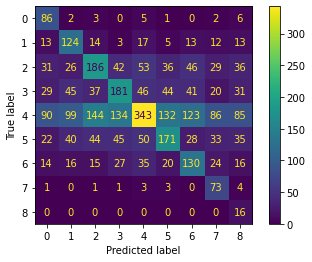

In [12]:
f1, report = evaluate_model(baseline_clf)

In [13]:
f1

0.3932924201680839

In [14]:
print(report)

              precision    recall  f1-score   support

           0       0.30      0.82      0.44       105
           1       0.35      0.58      0.44       214
           2       0.42      0.38      0.40       485
           3       0.42      0.38      0.40       474
           4       0.62      0.28      0.38      1236
           5       0.42      0.37      0.39       468
           6       0.34      0.44      0.38       297
           7       0.26      0.85      0.40        86
           8       0.07      1.00      0.12        16

    accuracy                           0.39      3381
   macro avg       0.36      0.57      0.37      3381
weighted avg       0.47      0.39      0.39      3381



In [15]:
# cross_val_score(baseline_clf, x_resampled["content"], y_resampled, cv=5)

## Naive Bayes

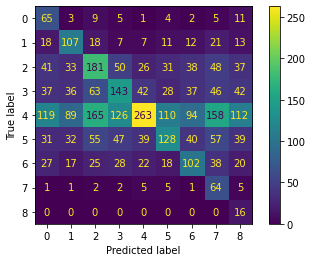

In [16]:
f1, report = evaluate_model(naive_bayes_clf)

In [17]:
f1

0.3285717003824697

In [18]:
print(report)

              precision    recall  f1-score   support

           0       0.19      0.62      0.29       105
           1       0.34      0.50      0.40       214
           2       0.35      0.37      0.36       485
           3       0.35      0.30      0.32       474
           4       0.65      0.21      0.32      1236
           5       0.38      0.27      0.32       468
           6       0.31      0.34      0.33       297
           7       0.15      0.74      0.24        86
           8       0.05      1.00      0.10        16

    accuracy                           0.32      3381
   macro avg       0.31      0.49      0.30      3381
weighted avg       0.45      0.32      0.33      3381



## K-Nearest Neighbors

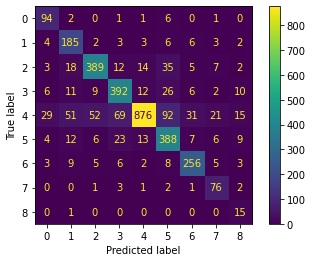

In [19]:
f1, report = evaluate_model(k_nearest_neighbors_clf)

In [20]:
f1

0.794943688262477

In [21]:
print(report)

              precision    recall  f1-score   support

           0       0.66      0.90      0.76       105
           1       0.64      0.86      0.74       214
           2       0.84      0.80      0.82       485
           3       0.77      0.83      0.80       474
           4       0.95      0.71      0.81      1236
           5       0.69      0.83      0.75       468
           6       0.82      0.86      0.84       297
           7       0.63      0.88      0.73        86
           8       0.26      0.94      0.41        16

    accuracy                           0.79      3381
   macro avg       0.69      0.85      0.74      3381
weighted avg       0.82      0.79      0.79      3381



## Decision Trees

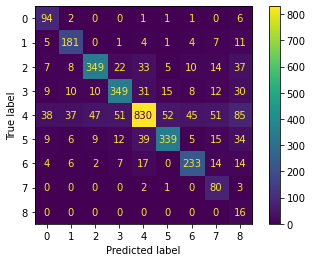

In [22]:
f1, report = evaluate_model(decision_tree_clf)

In [23]:
f1

0.7549612818031539

In [24]:
print(report)

              precision    recall  f1-score   support

           0       0.57      0.90      0.69       105
           1       0.72      0.85      0.78       214
           2       0.84      0.72      0.77       485
           3       0.79      0.74      0.76       474
           4       0.87      0.67      0.76      1236
           5       0.82      0.72      0.77       468
           6       0.76      0.78      0.77       297
           7       0.41      0.93      0.57        86
           8       0.07      1.00      0.13        16

    accuracy                           0.73      3381
   macro avg       0.65      0.81      0.67      3381
weighted avg       0.80      0.73      0.75      3381



## Random Forests

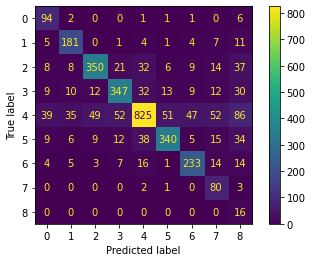

In [25]:
f1, report = evaluate_model(random_forest_clf)

In [26]:
f1

0.7535762370302269

In [27]:
print(report)

              precision    recall  f1-score   support

           0       0.56      0.90      0.69       105
           1       0.73      0.85      0.79       214
           2       0.83      0.72      0.77       485
           3       0.79      0.73      0.76       474
           4       0.87      0.67      0.75      1236
           5       0.82      0.73      0.77       468
           6       0.76      0.78      0.77       297
           7       0.41      0.93      0.57        86
           8       0.07      1.00      0.13        16

    accuracy                           0.73      3381
   macro avg       0.65      0.81      0.67      3381
weighted avg       0.80      0.73      0.75      3381



In [28]:
# cross_val_score(random_forest_clf, x_resampled["content"], y_resampled, cv=5)

## Gradient Boosting

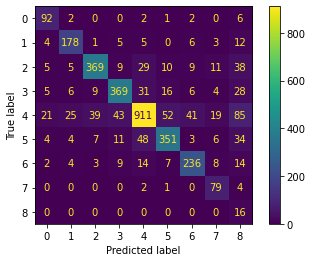

In [29]:
f1, report = evaluate_model(gradient_boosted_clf)

In [30]:
f1

0.7918239648603528

In [31]:
print(report)

              precision    recall  f1-score   support

           0       0.69      0.88      0.77       105
           1       0.79      0.83      0.81       214
           2       0.86      0.76      0.81       485
           3       0.83      0.78      0.80       474
           4       0.87      0.74      0.80      1236
           5       0.80      0.75      0.77       468
           6       0.78      0.79      0.79       297
           7       0.61      0.92      0.73        86
           8       0.07      1.00      0.13        16

    accuracy                           0.77      3381
   macro avg       0.70      0.83      0.71      3381
weighted avg       0.83      0.77      0.79      3381



## Extreme Gradient Boosting

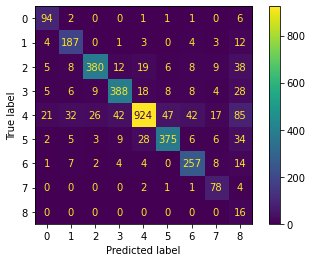

In [32]:
f1, report = evaluate_model(xg_boosted_clf)

In [33]:
f1

0.8220517090719828

In [34]:
print(report)

              precision    recall  f1-score   support

           0       0.71      0.90      0.79       105
           1       0.76      0.87      0.81       214
           2       0.90      0.78      0.84       485
           3       0.85      0.82      0.83       474
           4       0.92      0.75      0.83      1236
           5       0.86      0.80      0.83       468
           6       0.79      0.87      0.82       297
           7       0.62      0.91      0.74        86
           8       0.07      1.00      0.13        16

    accuracy                           0.80      3381
   macro avg       0.72      0.85      0.74      3381
weighted avg       0.86      0.80      0.82      3381



## Performance Evaluation
Out of all the models we can clearly see that our models all have similar precision and recall scores.
This can be seen in the classification reports which show a variety of metrics (all usually with similar scores).
For robustness though the F1 score shall be used to decipher which models perform best.


We can empirically see that basic logistic regression models perform with around ~40 accuracy.
The confusion matrix has both a bright diagonal and horizontal line.
The horizontal line at four indicates that average scores are being predicted more than anything else, despite the fact that we are working with reballanced data.
This is likely because there is a maximum amount of over sampling which can happen.
Although it is not shown here, substituting the oversampled training dataset with the original unaltered one will result in this to an extreme extent where the enumber four is almost the only the number predicted.


From the confusion matrix it is obvious that both Naive Bays and K-Nearest Neighbours classifiers have the exact same problem.
Although the problem is slightly exagerated in Naive Bays, K-Nearest Neighbours has predicts top scorers far more accuratly.


On the other hand, decision trees and random forests completely avoid the problem of predicting average scores far more frequently than anything else.
These models still struggle to predict high-scoring responses.
This can be read from the numbers, however is not visilbe in the confusion matrix due to the lack off data at these extremes.
Note that this is a problem with the underlying dataset and not the models here.


The boosting methods (ADA and Gradient) here perform very poorly.
This can be further confirmed by rerunning the notebook with different numbers of models within their ensembles.
The results being far worse in every metric than the baseline logistic regression emphasises the fact that the underlying data is not complex enough to use these boosted methods.
Overfitting has likely occured.